In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
df = pd.read_csv('./output/data/merged_df.csv')

In [110]:
df.columns

Index(['file_path', 'sampling_rate', 'rms', 'dbfs', 'label', 'duration',
       'mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean',
       'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean',
       'mfcc_9_mean', 'mfcc_10_mean', 'mfcc_11_mean', 'mfcc_12_mean',
       'mfcc_13_mean', 'mfcc_14_mean', 'mfcc_15_mean', 'mfcc_16_mean',
       'mfcc_17_mean', 'mfcc_18_mean', 'mfcc_19_mean', 'mfcc_20_mean',
       'mfcc_21_mean', 'mfcc_22_mean', 'mfcc_23_mean', 'mfcc_24_mean',
       'mfcc_25_mean', 'mfcc_26_mean', 'mfcc_27_mean', 'mfcc_28_mean',
       'mfcc_29_mean', 'mfcc_30_mean'],
      dtype='object')

In [111]:
# Drop the 'file_path' column
data = df.drop(columns=['file_path', 'sampling_rate'])

# Convert 'label' column values from 'fake' and 'real' to 0 and 1
data['label'] = data['label'].apply(lambda x: 0 if x == 'fake' else 1)

# Display the updated dataframe
data.head()

,rms,dbfs,label,duration,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,...,mfcc_21_mean,mfcc_22_mean,mfcc_23_mean,mfcc_24_mean,mfcc_25_mean,mfcc_26_mean,mfcc_27_mean,mfcc_28_mean,mfcc_29_mean,mfcc_30_mean
0,0.061510,-24.220951,1,6.840000,-304.358915,113.718140,-44.019962,28.249969,13.647294,-13.235131,...,-7.866895,-11.568779,-7.241586,-3.500644,-8.572959,-7.769196,-6.200805,-9.601032,-1.045484,1.696635
1,0.060355,-24.385653,1,6.070000,-288.427907,156.791671,-42.139863,21.732570,9.173440,-37.566173,...,-10.789220,-11.148569,-9.278637,-7.561083,-6.570046,-6.295412,-5.074236,-3.588240,-3.976979,-4.318006
2,0.034738,-29.183570,1,5.920000,-313.740666,133.639548,-45.765415,-0.657096,-4.961578,-27.818684,...,-7.803355,-3.843508,-4.639575,-5.083332,-2.645830,-3.523515,-4.064678,-1.823462,-1.784046,-3.711713
3,0.101507,-19.870003,1,9.849958,-338.537021,110.281378,-26.435818,7.775438,12.001120,-15.174507,...,-6.991075,-4.928947,-4.918112,-5.376414,-5.329774,-4.305240,-3.679742,-3.917728,-2.481780,-1.619357
4,0.027996,-31.057756,1,5.529958,-288.439310,117.138681,-53.475615,14.721516,-4.198275,-40.303515,...,-8.898795,-8.151491,-5.093298,0.412901,0.513141,1.108503,1.737505,-0.865436,0.617007,0.743553


In [112]:
data.shape

(17423, 34)

In [113]:
features = data.drop(columns=['label', 'rms', 'dbfs', 'duration'], axis=1).copy()
labels = data['label']

In [114]:
features.columns

Index(['mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean',
       'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean',
       'mfcc_9_mean', 'mfcc_10_mean', 'mfcc_11_mean', 'mfcc_12_mean',
       'mfcc_13_mean', 'mfcc_14_mean', 'mfcc_15_mean', 'mfcc_16_mean',
       'mfcc_17_mean', 'mfcc_18_mean', 'mfcc_19_mean', 'mfcc_20_mean',
       'mfcc_21_mean', 'mfcc_22_mean', 'mfcc_23_mean', 'mfcc_24_mean',
       'mfcc_25_mean', 'mfcc_26_mean', 'mfcc_27_mean', 'mfcc_28_mean',
       'mfcc_29_mean', 'mfcc_30_mean'],
      dtype='object')

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, LSTM, Bidirectional, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from utils import create_sequences
import pickle

In [116]:
# 1. Create sequences
sequence_length = 10  # Example value, adjust as needed
overlap = 5  # Example value, adjust as needed
print(features.shape)
sequences, indices = create_sequences(features, sequence_length, overlap)
labels = labels[indices]

# 2. Pad sequences
padded_sequences = pad_sequences(
    sequences, maxlen=2, padding="pre", truncating="post"
)

# 1. First split the data
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences, 
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# 2. Fit scaler only on training data
scaler = StandardScaler()
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)

# Fit on training, transform both
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)

# 3. Reshape back
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_val_scaled = X_val_scaled.reshape(X_val.shape)

(17423, 30)


In [117]:
# 2. Create LSTM model
model = Sequential()
input_shape = (padded_sequences.shape[1], padded_sequences.shape[2])
model.add(Input(shape=input_shape))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dense(32, activation='relu', kernel_regularizer='l2'))
model.add(Dense(1, activation='sigmoid'))

# 3. Compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, clipvalue=1.0), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss")
def scheduler(epoch, lr):
    if epoch > 0 and epoch % 3 == 0:
        return lr * 0.2
    return lr

reduce_lr = LearningRateScheduler(scheduler)

# 4. Training with separate validation data
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

with open('./output/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('./output/history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 196ms/step - accuracy: 0.7226 - loss: 0.9838 - val_accuracy: 0.8364 - val_loss: 0.4955 - learning_rate: 0.0010
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - accuracy: 0.8695 - loss: 0.4175 - val_accuracy: 0.8522 - val_loss: 0.3601 - learning_rate: 0.0010
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - accuracy: 0.8933 - loss: 0.2991 - val_accuracy: 0.8637 - val_loss: 0.3188 - learning_rate: 0.0010
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - accuracy: 0.9068 - loss: 0.2424 - val_accuracy: 0.8694 - val_loss: 0.3134 - learning_rate: 2.0000e-04
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 185ms/step - accuracy: 0.9146 - loss: 0.2311 - val_accuracy: 0.8780 - val_loss: 0.3239 - learning_rate: 2.0000e-04
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - accuracy: 0.9172 - loss: 0.2108 - val_accuracy: 0.8766 - val_loss: 0.3073 - learning_rate: 2.0000e-04
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - accuracy

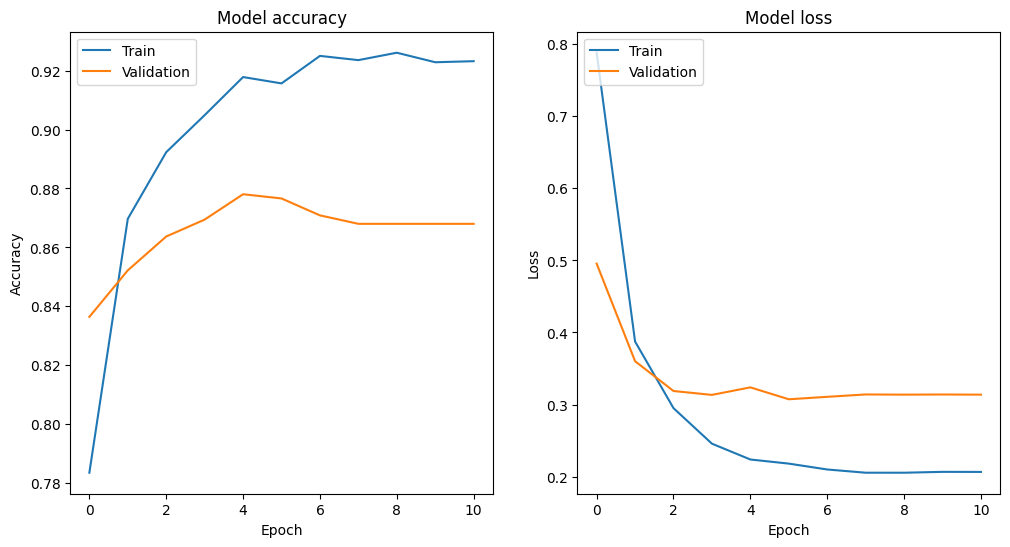

In [119]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# # Evaluate
# test_model = keras.models.load_model("best_model.keras")
# loss, accuracy = test_model.evaluate(X_test, y_test)
# print(f"Test Loss: {loss}")
# print(f"Test Accuracy: {accuracy}")